In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

# Transforms an image into a tensor
transform = transforms.Compose([
    torchvision.transforms.Resize((150,150)),
    torchvision.transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training data
trainData = torch.zeros(2000, 3, 150, 150)
trainLabels = torch.zeros(2000, dtype=torch.int8)
for i in range(1000):
    trainData[i] = transform(Image.open(f'./dogscats/subset/train/cats/cat.{i}.jpg'))
    trainLabels[i] = 1
for i in range(1000):
    trainData[i+1000] = transform(Image.open(f'./dogscats/subset/train/dogs/dog.{i}.jpg'))
    trainLabels[i+1000] = 0

# Load the validation data
validationData = torch.zeros(1000, 3, 150, 150)
validationLabels = torch.zeros(1000, dtype=torch.int8)
for i in range(500):
    validationData[i] = transform(Image.open(f'./dogscats/subset/validation/cats/cat.{i+1000}.jpg'))
    validationLabels[i] = 1
for i in range(500):
    validationData[i+500] = transform(Image.open(f'./dogscats/subset/validation/dogs/dog.{i+1000}.jpg'))
    validationLabels[i+500] = 0

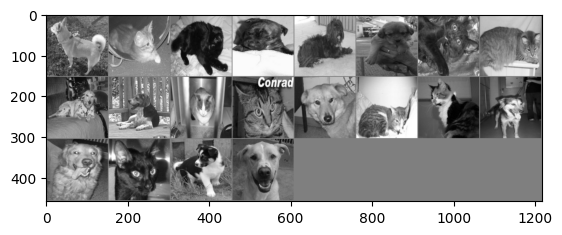

dog cat cat dog dog dog cat cat dog dog cat cat dog cat cat dog dog cat dog dog


In [8]:
# Show some training images to ensure tensors are correct(Unnecessary sanity check)
import matplotlib.pyplot as plt
import numpy as np
batch_size = 20
classes = ('dog', 'cat')
indices = torch.randperm(trainData.size(0))[:batch_size]
miniBatch = []
for i in indices:
    miniBatch.append([trainData[i], trainLabels[i]])
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid([item[0] for item in miniBatch]))
print(' '.join(f'{classes[miniBatch[j][1]]}' for j in range(batch_size)))

In [4]:
# Define the CNN modified from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.conv3 = nn.Conv2d(64, 128, (3,3))
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(6272, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x)
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

# Make the CNN use the GPU if possible
net = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
net = nn.DataParallel(net)
net.to(device)

Using device:  cuda


DataParallel(
  (module): Net(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout(p=0.5, inplace=False)
    (fc1): Linear(in_features=6272, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [27]:
# Train the CNN(Do not need to run since model already saved)
trainData.to(device)
trainLabels.to(device)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.0001)
history = torch.empty(4,100)
# Define function to augment the image
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomAffine(degrees=40,translate=(0,0.2), scale=(0.8,1.2), shear=(0.8,1.2,0.8,1.2)),
])
# Loop over the entire dataset 100 times(you can lower epochs if testing to see if it works)
for epoch in range(100):
    train_loss = 0.0
    val_loss = 0.0
    trainCorrect = 0
    trainTotal = 0
    # Run through 100 minibatches of the training data with size 20 each epoch
    for i in range(100):
        # Create a minibatch for training data
        indices = torch.randperm(trainData.size(0))[:batch_size]
        miniBatch = []
        for i in indices:
            miniBatch.append([augmentation(trainData[i]), trainLabels[i]])
        for i, data in enumerate(miniBatch, 0):
            input, label = data
            # Reset gradient
            optimizer.zero_grad()
            # Forwards pass
            output = net(input.to(device))
            # Convert data types so they can be compared
            output = output[0].to(torch.float64).to(device)
            label = label.to(torch.float64).to(device)
            # Record accuracy
            if(output >= 0.5):
                if(label == 1):
                    trainCorrect += 1
            else:
                if (label == 0):
                    trainCorrect += 1
            trainTotal += 1
            # Calculate binary cross entropy
            loss = criterion(output, label)
            train_loss += loss.item()
            # Backwards pass
            loss.backward()
            # Optimize
            optimizer.step()
    valCorrect = 0
    valTotal = 0
    # Run through 50 minibatches of the validation data with size 20 each epoch
    for i in range(50):
        # Create a minibatch for validation data
        indices = torch.randperm(validationData.size(0))[:batch_size]
        miniBatch = []
        for i in indices:
            miniBatch.append([validationData[i], validationLabels[i]])
        for i, data in enumerate(miniBatch, 0):
            input, label = data
            output = net(input.to(device))
            # Convert data types so they can be compared
            output = output[0].to(torch.float64).to(device)
            label = label.to(torch.float64).to(device)
            # Record accuracy
            if(output >= 0.5):
                if(label == 1):
                    valCorrect += 1
            else:
                if (label == 0):
                    valCorrect += 1
            valTotal += 1
            # Calculate binary cross entropy
            val_loss += criterion(output, label).item()
    # Print loss every epoch
    print(f'epoch: {epoch + 1} - loss: {train_loss / 2000:.3f} - acc: {trainCorrect/trainTotal:.3f} - val_loss: {val_loss / 2000:.3f} - val_acc: {valCorrect/valTotal:.3f}')
    history[0][epoch] = train_loss / 2000
    history[1][epoch] = trainCorrect/trainTotal
    history[2][epoch] = val_loss / 2000
    history[3][epoch] = valCorrect/valTotal

print('Finished Training')

epoch: 1 - loss: 0.692 - acc: 0.527 - val_loss: 0.345 - val_acc: 0.496
epoch: 2 - loss: 0.682 - acc: 0.579 - val_loss: 0.327 - val_acc: 0.631
epoch: 3 - loss: 0.670 - acc: 0.596 - val_loss: 0.318 - val_acc: 0.644
epoch: 4 - loss: 0.640 - acc: 0.642 - val_loss: 0.321 - val_acc: 0.639
epoch: 5 - loss: 0.635 - acc: 0.661 - val_loss: 0.290 - val_acc: 0.706
epoch: 6 - loss: 0.619 - acc: 0.658 - val_loss: 0.293 - val_acc: 0.695
epoch: 7 - loss: 0.618 - acc: 0.675 - val_loss: 0.279 - val_acc: 0.731
epoch: 8 - loss: 0.592 - acc: 0.698 - val_loss: 0.290 - val_acc: 0.684
epoch: 9 - loss: 0.589 - acc: 0.700 - val_loss: 0.271 - val_acc: 0.730
epoch: 10 - loss: 0.596 - acc: 0.680 - val_loss: 0.277 - val_acc: 0.721
epoch: 11 - loss: 0.582 - acc: 0.686 - val_loss: 0.253 - val_acc: 0.790
epoch: 12 - loss: 0.564 - acc: 0.709 - val_loss: 0.267 - val_acc: 0.731
epoch: 13 - loss: 0.557 - acc: 0.728 - val_loss: 0.269 - val_acc: 0.725
epoch: 14 - loss: 0.562 - acc: 0.713 - val_loss: 0.256 - val_acc: 0.762
e

In [29]:
# Save the model(Do not need to run)
import os
PATH = './model_gpu.pth'
#torch.save(net.state_dict(), PATH)
if not os.path.exists(PATH):
    torch.save(net.state_dict(), PATH)
else:
    print("File already exists, do not overwrite it")

File already exists, do not overwrite it


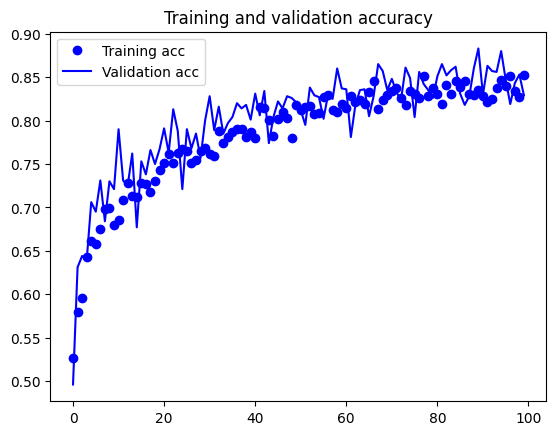

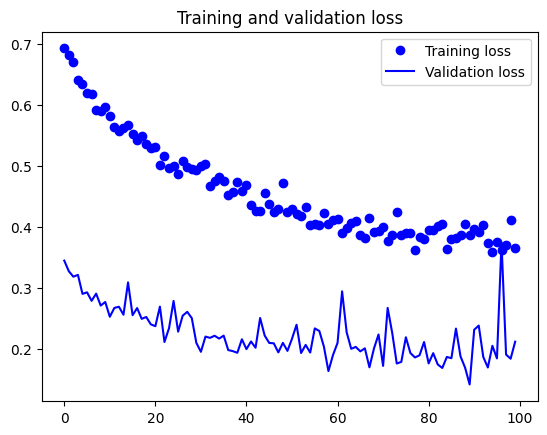

In [30]:
# Plot the accuracy and loss
epochs = range(100)
plt.plot(epochs, history[1], 'bo', label='Training acc')
plt.plot(epochs, history[3], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, history[0], 'bo', label='Training loss')
plt.plot(epochs, history[2], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [6]:
# Load the test data
testData = torch.zeros(1000, 3, 150, 150)
testLabels = torch.zeros(1000, dtype=torch.int8)
for i in range(500):
    testData[i] = transform(Image.open(f'./dogscats/subset/test/cats/cat.{i+1500}.jpg'))
    testLabels[i] = 1
for i in range(500):
    testData[i+500] = transform(Image.open(f'./dogscats/subset/test/dogs/dog.{i+1500}.jpg'))
    testLabels[i+500] = 0

acc:  0.842
True Negatives:  379
False Positives:  121
False Negatives:  37
True Positives:  463


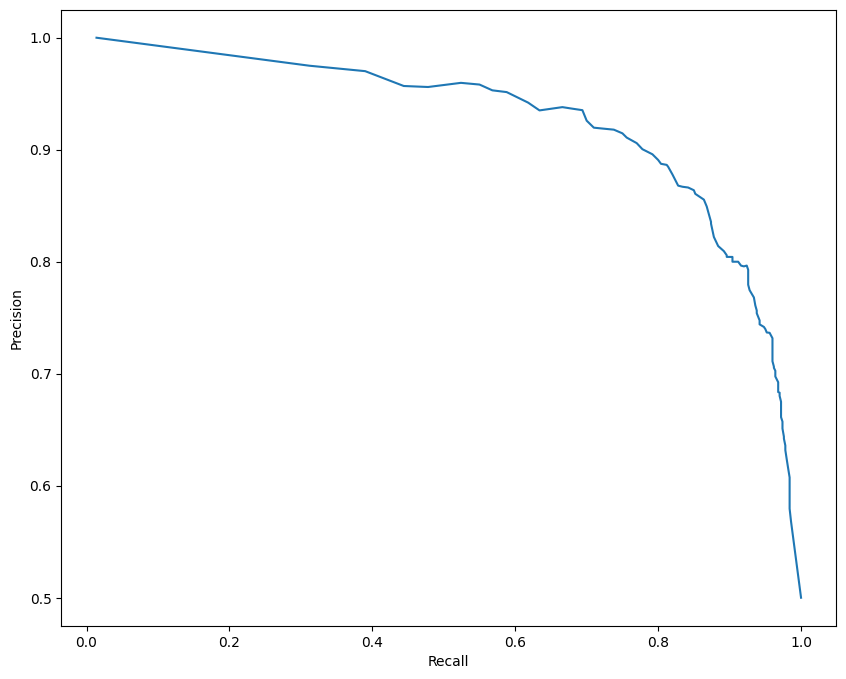

In [9]:
PATH = './model_gpu.pth'
net.load_state_dict(torch.load(PATH, weights_only=True), strict=False)
correct = 0
total = 0
thresholds = torch.linspace(0,1,101)
precision = torch.empty(thresholds.size(dim=0))
recall = torch.empty(thresholds.size(dim=0))
index = 0
max_f1 = 0
optimal_thresh = 0
predictions = torch.empty(testLabels.size(0))
for i in range(testLabels.size(0)):
    predictions[i] = net(testData[i])

with torch.no_grad():
    for threshold in thresholds:
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for i in range(testData.size(0)):
            if(predictions[i] >= threshold):
                if(testLabels[i] == 1):
                    tp += 1
                else:
                    fp += 1
            else:
                if(testLabels[i] == 0):
                    tn += 1
                else:
                    fn += 1
        if(fp == 0):
            precision[index] = 1
        else:
            precision[index] = float(tp)/(tp+fp)
        if(fn == 0):
            recall[index] = 1
        else:
            recall[index] = float(tp)/(tp+fn)
        index += 1
        if(threshold == 0.5):
            print("acc: ", float(tp+tn)/(tp+tn+fp+fn))
            print("True Negatives: ", tn)
            print("False Positives: ", fp)
            print("False Negatives: ", fn)
            print("True Positives: ", tp)
# Plot precision vs recall
plt.figure(figsize=[10,8])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall,precision)